# Possion Equation

## Reuglar case
Lets consider the problem of finding a function $u:\Omega=(0,1)\times(0,1)\rightarrow \mathbf{R}$ s.t.
$$\left\{\begin{aligned}
&-\Delta u=1\qquad in\ \Omega\\
&u=0\qquad on\ \partial \Omega
\end{aligned}\right.$$

In [3]:
import torch  
import torch.nn as nn
import torch.nn.functional as F

import numpy as np  
import matplotlib.pyplot as plt
import time

from mesh import *
from utils import *
from bf import *
from condition import *

from torch import tensor as Tensor
from torch import matmul as matmul

bfltest = [] # basis function list
for _ in range(Nelt):
    bf = basisref()
    bfltest.append(bf)


def totensor(n):
    return Tensor(n, dtype=torch.float32)


### compute the intergral on each cell

$$\int_E \nabla u \cdot \nabla vd\Omega - \int_{\partial E}\nabla u \cdot \textbf{n} v ds = \int_E fvd\Omega$$

In [ ]:

def intE(bflist, noe, notf):
    '''
    integral of $\nabla u \nabla v$ on kth element E
    ith test function
    '''
    w = Tensor([1.0/6, 1.0/6, 1.0/6])
    points = [[2.0/3, 1.0/6], [1.0/6, 1.0/6], [1.0/6, 2.0/3]]
    points = sample_triangle(5)
    NG = w.shape[0]
    
    T = Tensor(0.0)
    F = Tensor(0.0)

    E = meshelt[noe]
    bf = bflist[noe]
    p1 = meshvertex[E.vertex[0]]; p2 = meshvertex[E.vertex[1]]; p3 = meshvertex[E.vertex[2]]

    BE, bE = computeBE(p1, p2, p3)
    invBE = torch.inverse(BE).t()
    detBE = torch.det(BE)
    
    for k in range(NG):
        p = Tensor(points[k], requires_grad=True)
        realcor = hat2E(BE, bE, p)
        phii = phi.get(notf)(p)
        gphii = grad_phi.get(notf)(p)
        # print('ok')
        f = source(realcor)
        u = bf(p); 
        # u.backward(); gbf = p.grad
        gbf = torch.autograd.grad(u, p, create_graph=True, retain_graph=True)[0] 

        # print(gbf)
        T += detBE * w[k] * torch.dot(matmul(invBE, gbf), matmul(invBE, gphii))
        F += w[k] * detBE * f * phii
        # bf.zero_grad()
    return T, F

# print(intE(bfltest, 0,1))


################################################################################################################
def normvec(e: face):
    '''norm vector from E1 point to E2'''
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    v0 = p2 - p1
    if e.bctype == 0:
        E1 = meshelt[e.neighbor[0]]; E2 = meshelt[e.neighbor[1]]
        # print(e.neighbor[0], e.neighbor[1])
        inx = np.array([e.vertex[0], e.vertex[1]])
        n1 = E1.vertex[~np.isin(E1.vertex, inx)][0]
        n2 = E2.vertex[~np.isin(E2.vertex, inx)][0]
        # print(n1, n2)
        v1 = meshvertex[n2] - meshvertex[n1]
        tmpvec = np.array([-v0[1], v0[0]])
        t = np.dot(v1, tmpvec)
        if t > -1e-10:
            return totensor(tmpvec / np.linalg.norm(tmpvec))
        else:
            return totensor(-tmpvec / np.linalg.norm(tmpvec))
    elif e.bctype == 1:
        E1 = meshelt[e.neighbor[0]]
        inx = np.array([e.vertex[0], e.vertex[1]])
        n1 = E1.vertex[~np.isin(E1.vertex, inx)][0]
        v1 = meshvertex[n1] - p1
        tmpvec = np.array([-v0[1], v0[0]])
        t = np.dot(v1, tmpvec)
        if t > -1e-10:
            return totensor(-tmpvec / np.linalg.norm(tmpvec))
            
        else:
            return totensor(tmpvec / np.linalg.norm(tmpvec))

##################################################################################################
def inte(bflist, noe, notf):
    '''
    intergral of functions on neighbour cell E of edge e 
    '''
    e = meshface[noe]
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    leng = length(p1, p2)
    nvec = normvec(e)
    s = [-0.86113631, -0.33998104, 0.33998104, 0.86113631]
    w = Tensor([0.17392742, 0.32607257, 0.32607257, 0.17392742])
    NG = w.shape[0]
    A = Tensor(0.0)
    S = Tensor(0.0)
    J = Tensor(0.0)
    D = Tensor(0.0)
    
    if e.bctype == 0:
        n1 = e.neighbor[0]; n2 = e.neighbor[1]
        E1 = meshelt[n1]; E2 = meshelt[n2]
        BE1, bE1 = computeBE(meshvertex[E1.vertex[0]], meshvertex[E1.vertex[1]], meshvertex[E1.vertex[2]])
        BE2, bE2 = computeBE(meshvertex[E2.vertex[0]], meshvertex[E2.vertex[1]], meshvertex[E2.vertex[2]])
        invBE1 = torch.inverse(BE1).t()
        invBE2 = torch.inverse(BE2).t()
        # print(n1, n2)
        bf1 = bflist[n1]; bf2 = bflist[n2]

        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE1 = E2hat(BE1, bE1, realcor)
            refcorE2 = E2hat(BE2, bE2, realcor)

            phi1 = phi.get(notf)(refcorE1)
            gphi1 = grad_phi.get(notf)(refcorE1)
            phi2 = phi.get(notf)(refcorE2)
            gphi2 = grad_phi.get(notf)(refcorE2)
            

            tp1 = refcorE1.clone().requires_grad_(True)
            tp2 = refcorE2.clone().requires_grad_(True)

            u1 = bf1(tp1); u2 = bf2(tp2)
            # u1.backward(); gu1 = tp1.grad
            # u2.backward(); gu2 = tp2.grad
            gu1 = torch.autograd.grad(u1, tp1, create_graph=True, retain_graph=True)[0] 
            gu2 = torch.autograd.grad(u2, tp2, create_graph=True, retain_graph=True)[0] 

            jump =torch.squeeze(u1) - torch.squeeze(u2)

            A -= 0.5 * w[k] * leng * torch.dot(matmul(invBE1, gu1)+matmul(invBE2, gu2), nvec) * (phi1 - phi2)
            S += eps * 0.5 * w[k] * leng * torch.dot(matmul(invBE1, gphi1)+matmul(invBE2, gphi2), nvec) * jump
            J += sigma * w[k] * jump * (phi1 - phi2)
            # bf1.zero_grad(); bf2.zero_grad()
        return A, S, J
    
    elif e.bctype == 1:
        n = e.neighbor[0]
        E = meshelt[n]
        BE, bE = computeBE(meshvertex[E.vertex[0]], meshvertex[E.vertex[1]], meshvertex[E.vertex[2]])
        invBE = torch.inverse(BE).t()
        bf = bflist[n]

        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE = E2hat(BE, bE, realcor)
            
            phi1 = phi.get(notf)(refcorE)
            gphi1 = grad_phi.get(notf)(refcorE)

            tp = refcorE.clone().requires_grad_(True)
            u = bf(tp); uu = torch.squeeze(u)
            # u.backward(); gu = tp.grad
            gu = torch.autograd.grad(u, tp, create_graph=True, retain_graph=True)[0] 
            # print(gu)
            A -= w[k] * leng * torch.dot(matmul(invBE, gu), nvec) * phi1
            S += eps * w[k] * leng * torch.dot(matmul(invBE, gphi1), nvec) * uu
            J += sigma * w[k] * uu * phi1
            D += w[k] * (leng * eps * torch.dot(matmul(invBE, gphi1), nvec) + sigma * phi1) * dirichlet(realcor)
            # bf.zero_grad()
        return A, S, J, D

# print(inte(bfltest, 0, 0))

def trainplug(bflist):
    for i in range(Nelt):
        bflist[i].train()
def evalplug(bflist):
    for i in range(Nelt):
        bflist[i].eval()
def aggpara(bflist):
    parameters = list()
    for i in range(Nelt):
        parameters += list(bflist[i].parameters())
    return parameters
# aggpara()

class DGNet:
    def __init__(self) -> None:
        bflist = [] # basis function list
        for _ in range(Nelt):
            bf = basisref()
            bflist.append(bf)
        self.models = bflist
        self.parameters = aggpara(self.models)
        self.lbfgs = torch.optim.LBFGS(self.parameters, lr=0.001, max_iter=50000, max_eval=50000, history_size=50, tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps, line_search_fn='strong_wolfe')
        self.adam = torch.optim.Adam(self.parameters, lr=1.0)
        self.iter = 1 
        self.maxIter = 5000
        self.eqw = 1.0
        self.bdw = 1.0
        self.lr_decay = 2
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, 1, gamma=(1. - self.lr_decay/self.maxIter), 
                                                         last_epoch=-1)

    def lossfunc(self):
        eqloss = Tensor(0.0)
        bdloss = Tensor(0.0)
        for i in range(Nloc):
            for k in range(Nelt):
                A, B = intE(self.models, k ,i)
                eqloss += A - B
            for k in range(Nface):
                if meshface[k].bctype == 0:
                    C, S, J = inte(self.models, k, i)
                    eqloss += C 
                    bdloss += S + J
                elif meshface[k].bctype == 1:
                    C, S, J, D = inte(self.models, k, i)
                    eqloss += C 
                    bdloss += S + J - D
            # print('loss', i, loss, tmploss)
        # loss = self.eqw * eqloss ** 2 + self.bdw * bdloss ** 2
        loss =  (eqloss + bdloss) ** 2

        if self.iter % 10 == 0:
            print(f"The {self.iter}th training, loss is {loss.item()}")
        self.iter += 1
        return loss
    
    def train(self, niter):
        # try:
        #     self.loadmodel()
        #     print('########################## A trained model has been loaded #############################')
        # except:
        #     print('########################## Started with a new model #############################')
        trainplug(self.models)
        for _ in range(niter):
            self.adam.zero_grad()
            loss = self.lossfunc()
            if loss<1e-2:
                break
            loss.backward()
            self.adam.step()
            # self.scheduler.step()

    def eval(self):
        evalplug(self.models)

    def loadmodel(self):
        for i in range(Nelt):
            net = basisref()
            para = torch.load(f"./model/net{i}.pth")
            net.load_state_dict(para)
            self.models[i] = net


    def save(self):
        save_paths = ["./model/net{}.pth".format(i) for i in range(Nelt)]
        for i, net in enumerate(self.models):  
            path = save_paths[i]  
            torch.save(net.state_dict(), path)  


In [2]:
model = DGNet()
print('############################# Begin training! #############################')
model.train(1000)
print('############################# Finish training! #############################')
model.eval()
print('############################# Save Model #############################')
model.save()

############################# Begin training! #############################
########################## Started with a new model #############################
The 10th training, loss is 39920924.0
The 20th training, loss is 9251311.0
The 30th training, loss is 907343.4375
The 40th training, loss is 331581.40625
The 50th training, loss is 572486.5625
The 60th training, loss is 27580.65625
The 70th training, loss is 35062.58203125
The 80th training, loss is 29054.9140625
The 90th training, loss is 9375.3642578125
The 100th training, loss is 2914.60693359375
The 110th training, loss is 1165.2833251953125
The 120th training, loss is 494.7252197265625
The 130th training, loss is 128.6968994140625
The 140th training, loss is 2.3982906341552734
The 150th training, loss is 13.2472562789917
The 160th training, loss is 6.058777332305908
The 170th training, loss is 0.6836934089660645
The 180th training, loss is 0.9114552736282349
The 190th training, loss is 0.3309539556503296
The 200th training, l

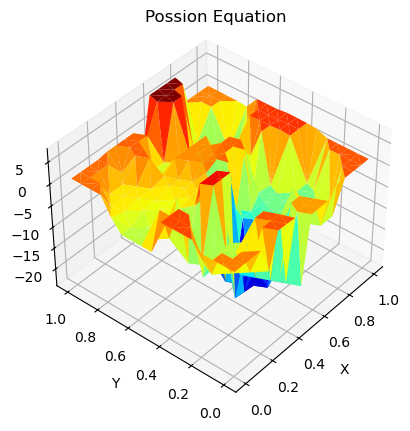

In [4]:
def basisphy(bflist, k, p):
    # p is real coordinates, function on real physical domain
    E = meshelt[k]
    p1 = meshvertex[E.vertex[0]]; p2 = meshvertex[E.vertex[1]]; p3 = meshvertex[E.vertex[2]]
    BE, bE = computeBE(p1, p2, p3)
    refcor = E2hat(BE, bE, p)
    if is_in_ref(refcor) != -1:
        return bflist[k](refcor)
    else:
        print("outside")
        return 0

def plot3D(): 
    fig = plt.figure()    
    n_inter = 5
    p_inter = totensor(sample_triangle(n_inter))
    N_inter = p_inter.shape[0]
    N_tol = Nelt * N_inter
    sol = torch.zeros(N_tol)
    plot_p = torch.zeros((N_tol, 2))
    for i in range(Nelt):
        for j in range(N_inter):
            n1 = Mesh[i][0]; n2 = Mesh[i][1]; n3 = Mesh[i][2]
            p1 = meshvertex[n1]; p2 = meshvertex[n2]; p3 = meshvertex[n3]; 
            BE, bE = computeBE(p1, p2, p3)
            ie = i * N_inter + j
            real_p = hat2E(BE, bE, p_inter[j])

            sol[ie] = basisphy(model.models,i, real_p)
            plot_p[ie] = real_p
    plot_p = plot_p.detach().numpy()  
    sol = sol.detach().numpy()  
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=40, azim=220)
    ax.plot_trisurf(plot_p[:, 0], plot_p[:, 1], sol, cmap='jet')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Possion Equation')
    plt.show()
plot3D()

In [2]:
print(sample_triangle(5))

[[0.   0.  ]
 [0.25 0.  ]
 [0.5  0.  ]
 [0.75 0.  ]
 [1.   0.  ]
 [0.   0.25]
 [0.25 0.25]
 [0.5  0.25]
 [0.75 0.25]
 [0.   0.5 ]
 [0.25 0.5 ]
 [0.5  0.5 ]
 [0.   0.75]
 [0.25 0.75]
 [0.   1.  ]]
